### Este cuaderno de jupyter genera datos para un contaminante y estacion dadas por un ragon de tiempo según sean datos horarios o diarios del portal de datos abiertos de la CAM

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import collections
import itertools
import datetime
from scipy.fft import fft # Herramienta matematica que nos permite extraer los periodos o frecuencias características de una señal
from scipy.fftpack import fftfreq # Rutina matematica para obtener periodos 

### Cargado de datos en bruto 

En esta celda simplemente estamos volcando toda la información disponible en el portal de datos abiertos de Madrid referente a las observaciones de contaminante en las distintas estaciones de monitoreo diseminadas por la comunidad de Madrid. Los datos deben estar en local, la aplicación no se conecta a internet para descargarlos.

In [3]:
# La dirección de los datos diarios es la siguiente
directorioDatosHorarios = './datosHorariosContaminacion/'

# Lista con dataFrames de los datos en el formato ofrecido por la CAM
# Tenemos para todos los meses y años.

# De la ciudad de Madrid
meses = np.array(['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic'])
years_csv = np.array(['_mo10.csv','_mo11.csv','_mo12.csv','_mo13.csv','_mo14.csv','_mo15.csv','_mo16.csv','_mo17.csv','_mo18.csv','_mo19.csv','_mo20.csv','_mo21.csv'])
# De la CAM
mesesCam = np.array(['_01.csv','_02.csv','_03.csv','_04.csv','_05.csv','_06.csv','_07.csv','_08.csv','_09.csv','_10.csv','_11.csv','_12.csv'])
yearsCam_csv = np.array(['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021'])

# Se implementa el siguiente producto cartesiano para tener los nombres de todos los ficheros
ficheros = np.asarray([ [ mes+ycsv for mes in meses] for ycsv in years_csv[0:11]]).reshape(len(meses)*len(years_csv[0:11]))
# Esto es porque los datos no estan para los 12 meses del año 21 y por lo tanto la operación anterior sobre todos los años no devolvería una estuctura rectangular
ficheros = np.concatenate(( ficheros, np.asarray([ mes+years_csv[-1] for mes in meses[0:-2] ] )))

# Se implementa el siguiente producto cartesiano para tener los nombres de todos los ficheros
ficherosCam = np.asarray([ [ ycsv+mes for mes in mesesCam] for ycsv in yearsCam_csv[0:-1]]).reshape(len(mesesCam)*len(yearsCam_csv[0:-1]))
# Esto es porque los datos no estan para los 12 meses del año 21 y por lo tanto la operación anterior sobre todos los años no devolvería una estuctura rectangular
ficherosCam = np.concatenate(( ficherosCam, np.asarray([ yearsCam_csv[-1]+mes for mes in mesesCam[0:-2] ] )))

ficherosCam = ficherosCam.reshape(len(mesesCam)*len(yearsCam_csv[0:-1])+len(mesesCam[0:10]))

# Concatenamos todos los nombres de los ficheros
ficheros = np.concatenate((ficherosCam,ficheros))

# Cargamos dataframes
datosHorariosAnuales_ls_pd = [ pd.read_csv(directorioDatosHorarios+fichero, sep =';').fillna(0) for fichero in ficheros]

# Debemos asegurarnos de que las columnas sean consistentes. Vamos a convertir a mayúsculas los nombres
[df.set_axis([col.upper() for col in df.columns], axis=1, inplace=True) for df in datosHorariosAnuales_ls_pd]

# Se concatenan finalmente los dataframes
datosHorariosAnuales_pd = pd.concat(datosHorariosAnuales_ls_pd, axis=0, ignore_index=True)

display(datosHorariosAnuales_pd)

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,102,1,1,28102001_1_38,2005,1,1,0.00,N,...,0.00,N,0.00,N,0.00,N,0.00,N,0.00,N
1,28,102,1,6,28102001_6_48,2005,1,1,0.00,N,...,0.00,N,0.00,N,0.00,N,0.00,N,0.00,N
2,28,102,1,7,28102001_7_8,2005,1,1,0.00,N,...,0.00,N,0.00,N,0.00,N,0.00,N,0.00,N
3,28,102,1,8,28102001_8_8,2005,1,1,0.00,N,...,0.00,N,0.00,N,0.00,N,0.00,N,0.00,N
4,28,102,1,10,28102001_10_49,2005,1,1,0.00,N,...,0.00,N,0.00,N,0.00,N,0.00,N,0.00,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481017,28,79,60,14,28079060_14_6,2021,10,27,9.18,V,...,52.52,V,32.82,V,13.82,V,7.48,V,7.36,V
1481018,28,79,60,14,28079060_14_6,2021,10,28,12.10,V,...,60.64,V,45.30,V,49.80,V,56.60,V,53.70,V
1481019,28,79,60,14,28079060_14_6,2021,10,29,51.32,V,...,15.58,V,9.40,V,19.67,V,36.61,V,43.96,V
1481020,28,79,60,14,28079060_14_6,2021,10,30,43.62,V,...,29.93,V,31.90,V,32.16,V,33.56,V,31.14,V


### Procesado de los datos para obtener las series temporales de interés

En esta otra celda, se extrae toda la serie temporal **horaria** disponible para los municipios, moléculas y estaciones indicadas.

Horaria quiere decir hora a hora, más tarde podemos manipularlo para que sea díaria, mensual...

In [9]:
def procesadoExtraccionSeriesTemporales(municipios,nombresMunicipios,magnitudes,nombresMagnitudes,estaciones):
    '''
    
    Esta función encapsula la funcionalidad de que dados los parámetros de municipio, magnitudes y estaciones, devuelve un 
    DataFrame con la información solicitada en formato de serie temporal horaria.
    
    Las siguientes lineas de código ahora están comentadas pero para recordar el formato en el que deben introducirse las funciones para que funcione bien


    # Los parametros indicados deben cotejarse con la información del .pdf concerniente a los portales de datos abiertos de Madrid y la CAM

    ### Seleccionamos magnitud y estación
    provincia = 28

    # Es importante que las posiciones de las dos siguientes listas coincidan el número de municipio con su nombre 
    municipios = [49,148]
    nombresMunicipios = ['pueblo','torrejon']
    
    
    # Las estaciones. Debe indicarse también la estación de la que extraemos datos. Ciertos municipios como Madrid tienen varios.
    estaciones = [3,4]

    # Es importante que las posiciones de las dos siguientes listas coincidan el número de magnitud con su nombre 
    magnitudes = [8,14,7] 
    nombresMagnitudes = ['NO2','O3','NO']



    OJO esta función es pesada por lo que hay que evitar invocarla muchas veces para no hacer pesado los cálculos.

    '''
    
    # Esto no va a cambiar
    provincia = 28

    # Operacion de concatenacion con los nombres
    nombresColumnas = [
       nombresMagnitudes,
       nombresMunicipios
    ]

    datosHorariosAnualesFechaEspecificos_pd = datosHorariosAnuales_pd[(datosHorariosAnuales_pd.PROVINCIA==provincia) &
                                                                 (datosHorariosAnuales_pd.MUNICIPIO.isin(municipios)) & 
                                                                 (datosHorariosAnuales_pd.ESTACION.isin(estaciones)) & 
                                                                 (datosHorariosAnuales_pd.MAGNITUD.isin(magnitudes))  ]

    # Se crea una columna que resulte de concatenar mes y año, que vienen a ser un valor compartido de cuando hay medidas o no diarias
    datosHorariosAnualesFechaEspecificos_pd['year_month_day'] = pd.to_datetime(datosHorariosAnualesFechaEspecificos_pd['DIA'].astype(str).values
                                                                          +'-'+datosHorariosAnualesFechaEspecificos_pd['MES'].astype(str).values
                                                                          +'-'+datosHorariosAnualesFechaEspecificos_pd['ANO'].astype(str).values,format='%d-%m-%Y')

    # Se van a eliminar aquellos dias en los que no haya medidas para todas las magnitudes
    # Hacemos un agrupado para poder separar por magnitud y ordenar cada dataframe por las fechas. Posteriormente extraer sus valores
    agrupados_por_fecha = datosHorariosAnualesFechaEspecificos_pd.groupby('year_month_day')
    dataFrames_por_fecha = [ agrupados_por_fecha.get_group(grupo) for grupo in agrupados_por_fecha.groups]


    # De aqui deben eliminarse los dataframes por fecha que no contengan todas las magnitudes de interes
    # Se hace de esta forma para evitar un error de que no pueda compararse por etiquetas idénticas
    n = len(dataFrames_por_fecha)
    for _i, df in enumerate(dataFrames_por_fecha[::-1], 1):
        if not (collections.Counter(list(df['MAGNITUD'].values)) == collections.Counter(magnitudes*len(estaciones))):
            dataFrames_por_fecha.pop(n - _i)


    # Concatenamos de vuelta, ya habiendo eliminado aquellos días en los que uno u otro contaminante seleccionado
    # están ausentes        
    datosHorariosAnualesFechaEspecificos_pd = pd.concat(dataFrames_por_fecha)

    # fechas propiamente dichas, que seran almacenadas como columna en el documento final
    # No todos los archivos de .csv tienen información para todos los dias
    # Debemos concatenar Series con los días en los que sí hay medidas
    # Debemos restringir las fechas a una magnitud cualesquiera para evitar duplicados
    anno_np = datosHorariosAnualesFechaEspecificos_pd[(
                                                (datosHorariosAnualesFechaEspecificos_pd.MAGNITUD ==magnitudes[0])  & 
                                                (datosHorariosAnualesFechaEspecificos_pd.MUNICIPIO==municipios[0])  &
                                                (datosHorariosAnualesFechaEspecificos_pd.ESTACION ==estaciones[0])
                                                      )]['ANO'].astype(int).astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    mes_np  = datosHorariosAnualesFechaEspecificos_pd[(
                                               (datosHorariosAnualesFechaEspecificos_pd.MAGNITUD ==magnitudes[0])  & 
                                               (datosHorariosAnualesFechaEspecificos_pd.ESTACION ==estaciones[0]) &
                                               (datosHorariosAnualesFechaEspecificos_pd.MUNICIPIO==municipios[0])
                                                      )]['MES'].astype(int).astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    dia_np  = datosHorariosAnualesFechaEspecificos_pd[(
                                               (datosHorariosAnualesFechaEspecificos_pd.MAGNITUD ==magnitudes[0])  & 
                                               (datosHorariosAnualesFechaEspecificos_pd.ESTACION ==estaciones[0]) & 
                                               (datosHorariosAnualesFechaEspecificos_pd.MUNICIPIO==municipios[0]) 
                                                     )]['DIA'].astype(int).astype(str).apply(lambda x: '{0:0>2}'.format(x)).values

    anno_mes_dia_S = pd.Series(anno_np+mes_np+dia_np)
    # Para cada fecha almacenada en la serie anterior, se deben tener fechas para cada hora (hasta 24 horas)
    fechas_pd = pd.DataFrame({},dtype='datetime64[s]',columns=['fecha'])
    for fecha in anno_mes_dia_S.values:
        a_day_pd = pd.DataFrame(pd.date_range(start=fecha, periods=24,freq='H'),columns=['fecha'])
        fechas_pd = fechas_pd.append(a_day_pd)


    # Registramos el número de fechas unívocas. Pero para cada fecha puede haber horas en los que las medidas de un contaminante sean validas pero la de otras no, ojo
    registros = len(datosHorariosAnualesFechaEspecificos_pd.groupby(datosHorariosAnualesFechaEspecificos_pd.year_month_day.tolist(),as_index=False).size())

    # Hacemos un agrupado para poder separar por magnitud, municipio y estacion y ordenar cada dataframe por las fechas. Posteriormente extraer sus valores
    agrupados_por_magnitud = datosHorariosAnualesFechaEspecificos_pd.groupby(['MUNICIPIO','ESTACION','MAGNITUD'])
    dataFrames_por_magnitud = [ agrupados_por_magnitud.get_group(grupo).sort_values('year_month_day') for grupo in agrupados_por_magnitud.groups]


    # Si estan ordenados, el siguiente reshape debe separar por columnas las diferentes magnitudes que estamos incluyendo en el estudio
    datosHorariosAnualesEspecificos_medicion_np   = np.asarray([np.reshape(grupo[[f'H{i:>02}' for i in range(1,25)]].values,(24*registros)) for grupo in dataFrames_por_magnitud])
    datosHorariosAnualesEspecificos_validacion_np = np.asarray([np.reshape(grupo[[f'V{i:>02}' for i in range(1,25)]].values,(24*registros)) for grupo in dataFrames_por_magnitud])

    # Nombres de las columnas con los datos. Contiene información relativa al origen y naturaleza de los datos
    identificadorSerie = np.asarray([grupo[['MUNICIPIO','ESTACION','MAGNITUD']].values[0,:] for grupo in dataFrames_por_magnitud])
    columnas = [nombresMunicipios[municipios.index(A)]+'_'+nombresMagnitudes[magnitudes.index(B)] for A,B in zip(identificadorSerie[:,0],identificadorSerie[:,2])] + ['fecha']

    # Si asumimos que el tiempo va continuamente avanzando, el siguiente rango de enteros son las fechas separadas por un paso temporal de una hora
    indicesDatosHorarios = np.arange(24*registros)

    # Creamos una mascara con las mediciones no validas para cada magnitud. 
    # Se concatenan los caracteres de cada medicion en una
    validacionesConcatenadas = np.asarray([ np.sum(datosHorariosAnualesEspecificos_validacion_np[:,i]) for i in range(24*registros)])


    # Finalmente, solo debemos retener los registros en que todos sean "V"
    medicionesValidas = validacionesConcatenadas == 'V'*(len(magnitudes)*len(estaciones))


    # Se extraen los índices validos
    indicesDatosHorariosValidos = indicesDatosHorarios[medicionesValidas]


    # Nuestra serie temporal de datos Diarios volcada en un dataframe
    datosHorariosAnualesEspecificos_medicion_np = datosHorariosAnualesEspecificos_medicion_np[:,indicesDatosHorariosValidos]
    fechas_np = fechas_pd.values
    fechasValidas_np = fechas_np[indicesDatosHorariosValidos]
    datosHorarios_pd = pd.DataFrame(np.zeros((len(indicesDatosHorariosValidos),len(columnas))),columns=columnas)

    # Como tenemos datetimes y números float, debemos hacer separadamente la integración en el dataframe
    datosHorarios_pd[columnas[0:-1]] = datosHorariosAnualesEspecificos_medicion_np.T
    datosHorarios_pd[columnas[-1]] = fechasValidas_np[:,0]

    # Ajustamos al fecha como índice del dataframe
    datosHorarios_pd = datosHorarios_pd.set_index(['fecha'])
    
    # Finalmente, la función nos devuelve los datos horarios
    return datosHorarios_pd


### En la siguiente celda, se visualiza los resultados obtenidos de forma general. 

Comprobamos en un vistazo que los datos tienen sentido, al menos en orden de magnitud, formato, de fecha...

In [10]:
datosHorarios_pd = procesadoExtraccionSeriesTemporales([49,148],['pueblo','torrejon'],[8,14,7],['NO2','O3','NO'],[3,4])
datosHorarios_pd

C:\Users\jgomezg\AppData\Local\Temp\ipykernel_85232\2043506962.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosHorariosAnualesFechaEspecificos_pd['year_month_day'] = pd.to_datetime(datosHorariosAnualesFechaEspecificos_pd['DIA'].astype(str).values


,pueblo_NO,pueblo_NO2,pueblo_O3,torrejon_NO,torrejon_NO2,torrejon_O3
fecha,,,,,,
2007-06-02 00:00:00,28.0,33.0,38.0,4.0,10.0,62.0
2007-06-02 01:00:00,26.0,30.0,41.0,4.0,17.0,51.0
2007-06-02 02:00:00,18.0,26.0,41.0,4.0,9.0,49.0
2007-06-02 03:00:00,24.0,25.0,34.0,3.0,10.0,47.0
2007-06-02 04:00:00,31.0,28.0,26.0,4.0,13.0,36.0
...,...,...,...,...,...,...
2021-10-31 19:00:00,2.0,11.0,39.0,1.0,11.0,28.0
2021-10-31 20:00:00,1.0,12.0,54.0,1.0,9.0,45.0
2021-10-31 21:00:00,2.0,10.0,60.0,1.0,8.0,52.0


### Generación de datos diarios u horarios

Primer nivel de procesado de datos. Podemos o bien, dejar los datos horarios tal cual u obtener promedios diarios. Si tenemos promedios diarios pasamos de tener aproximadamente 24 (horas)\*365 (días)\*10 (años) de observaciones a aproximadamente 365 (días)\*10 (Años) de datos, lo cual hace que cualquier calculo posterior sea mucho más liviano para nuestro ordenador.

In [23]:
def agregadoTemporal(datosHorarios_pd,temporalidad,nombreFichero):
    '''
    Esta función encapsula la funcionalidad de que introduciendo un DataFrame con los datos de contaminación en formato de serie temporal
    obtenidas de la función procesadoExtraccionSeriesTemporales(), dada una temporalidad deseada, horaria u diaria, almacena los datos
    ya finalmente para solo consultar esos y no estar constantemente invocando la otra función, mucho más pesada computacionalmente.
    
    
    temporalidad de momento admite los dos siguientes valores. 

    temporalidad = 'diario'
    temporalidad = 'horaria'
    
    
    Si elegimos temporalidad horaria, realmente la función no hace nada, porque los datos ya están así.

    El nombre del fichero debes proporcionarlo, es una cadena simple de carácteres, por ejemplo puede ser "datos_diarios_torrejon_no2"

    '''
    nombreFichero = nombreFichero+'.csv'
   
    # En función de la temporalidad, una cosa u la otra
    if temporalidad == 'diario':
        # Debemos agregar por dia para obtener el promedio de los contaminantes al dia
        datos_agregados_dia = datosHorarios_pd.groupby([datosHorarios_pd.index.year,datosHorarios_pd.index.month,datosHorarios_pd.index.day],axis='index') # Agregamos por días iguales
        datosDiarios_pd = datos_agregados_dia.mean()
        # Debemos crear nuevamente nuestras fechas, nos devuelve un dataframe con multi indice
        indices = datosDiarios_pd.index.values
        fechas = []
        for i, indice in enumerate(indices):
            fechas.append(datetime.datetime(indice[0],indice[1],indice[2]))
            indices[i] = list(indice)
        indice_fechas = np.asarray(fechas)
        datosDiarios_pd = datosDiarios_pd.set_index(indice_fechas)
        # Guardamos el .csv
        datosDiarios_pd.to_csv(nombreFichero,sep=';')
    elif temporalidad == 'horaria':
        # Ya son datos horarios, guardamos el .csv
        datosHorarios_pd.to_csv(nombreFichero,sep=';')
    else:
        raise Exception("Debes indicar claramente la cadena de carácteres diario u horario, no se ha hecho ninguna operación")
    
        
    return

### METEOROLOGÍA HORARIA

También tenemos disponible la meteorología horaria asociada a diversas estaciones de monitoreo

In [2]:
### DATOS HORARIOS

# La dirección de los datos diarios es la siguiente
directorioMeteoHorarios = './meteorologiaHoraria2019_2021/'

# Lista con dataFrames de los datos en el formato ofrecido por la CAM
# Tenemos para todos los meses y años.
meses = np.array(['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic'])
years_csv = np.array(['_meteo19.csv','_meteo20.csv','_meteo21.csv'])

# Se implementa el siguiente producto cartesiano para tener los nombres de todos los ficheros
ficheros = np.asarray([ np.asarray([ mes+ycsv for mes in meses]) for ycsv in years_csv[0:2] ]).reshape(len(meses)*len(years_csv[0:2]))
# Esto es porque los datos no estan para los 12 meses del año 21 y por lo tanto la operación anterior sobre todos los años no devolvería una estuctura rectangular
ficheros = np.concatenate(( ficheros, np.asarray([ mes+years_csv[-1] for mes in meses[0:-2] ] )))
ficheros = ficheros.reshape(len(meses)*len(years_csv[0:2])+len(meses[0:10]))
                     
meteoHorariosAnuales_ls_pd = [ pd.read_csv(directorioMeteoHorarios+fichero, sep =';') for fichero in ficheros]

# Se concatenan los dataframes
meteoHorariosAnuales_pd = pd.concat(meteoHorariosAnuales_ls_pd)

meteoHorariosAnuales_pd

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,102,81,28079102_81_98,2019,1,1,0.65,V,...,0.43,V,0.58,V,0.38,V,0.67,V,0.18,V
1,28,79,102,81,28079102_81_98,2019,1,2,0.50,V,...,0.53,V,1.13,V,2.02,V,3.48,V,2.82,V
2,28,79,102,81,28079102_81_98,2019,1,3,2.22,V,...,0.50,V,2.02,V,1.33,V,0.83,V,0.67,V
3,28,79,102,81,28079102_81_98,2019,1,4,0.87,V,...,0.13,V,0.58,V,0.92,V,0.20,V,0.33,V
4,28,79,102,81,28079102_81_98,2019,1,5,0.57,V,...,0.47,V,0.32,V,0.30,V,0.23,V,0.45,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,28,79,59,89,28079059_89_98,2021,10,27,0.00,V,...,0.00,V,0.00,V,0.00,V,0.00,V,0.00,V
2636,28,79,59,89,28079059_89_98,2021,10,28,0.00,V,...,0.00,V,0.00,V,0.00,V,0.00,V,0.00,V
2637,28,79,59,89,28079059_89_98,2021,10,29,0.00,V,...,1.80,V,1.80,V,1.80,V,1.80,V,3.60,V
2638,28,79,59,89,28079059_89_98,2021,10,30,4.00,V,...,0.00,V,0.00,V,0.10,V,1.40,V,0.00,V


In [4]:
### Seleccionamos magnitud y estación
provincia = 28
municipio = 79 
estacion = 102 # Estacion JMD centro

# Para la magnitud, vamos a tomar los siguientes
# magnitudes = [ 80 RADIACIÓN ULTRAVIOLETA Mw/m2, 81 VELOCIDAD VIENTO m/s, 82 DIR. DE VIENTO, 83 TEMPERATURA ºC, 86 HUMEDAD RELATIVA, 87 PRESION BARIOMETRICA mb, 88 RADIACION SOLAR W/m2, 89 PRECIPITACIÓN l/m2 ]
magnitudes = [81,82,83,86,87,88,89]

# Restringimos informacion a la estacion y magnitudes indicadas
meteoHorariosAnualesEspecificos_pd = meteoHorariosAnuales_pd[(meteoHorariosAnuales_pd.PROVINCIA==provincia) &
                                                             (meteoHorariosAnuales_pd.MUNICIPIO==municipio) & 
                                                             (meteoHorariosAnuales_pd.ESTACION==estacion) & 
                                                             (meteoHorariosAnuales_pd.MAGNITUD.isin(magnitudes))]


# Rango con todas las fechas que en principio deberían estar registradas en las estaciones de medida
rangoFechas = pd.date_range(start='20190101', end='20211101',freq='H') # Debo extender hasta un día más porque  de lo contrario acaba justo a las 00:00 del día 30 o lo que es lo mismo al principio del día 31
# Preparamos el futuro dataframe con la informacion a incluir
columnas = ['velW','velD','temp','hum','pres','ins','prec','fecha']
datos = np.zeros((len(rangoFechas),1+len(magnitudes))) ## La matriz de datos idealmente tiene esta estructura
meteoHorarios_pd = pd.DataFrame(datos,columns = columnas)
# Todas las fechas que en principio deberian estar registradas en las estaciones de medida
meteoHorarios_pd['fecha'] = rangoFechas

# Ahora se operara por magnitud a considerar
for magnitud in magnitudes:
    
    # No todos los archivos de .csv tienen información para todos los dias para cada magnitud
    # Debemos concatenar Series con los días en los que sí hay medidas
    anno_np = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['ANO'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    mes_np  = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['MES'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    dia_np  = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['DIA'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    anno_mes_dia_S = pd.Series(anno_np+mes_np+dia_np)
    # Para cada fecha almacenada en la serie anterior, se deben tener fechas para cada hora (hasta 24 horas)
    fechas_pd = pd.DataFrame({},dtype='datetime64',columns=['fechas'])
    for fecha in anno_mes_dia_S.values:
        a_day_pd = pd.DataFrame(pd.date_range(start=fecha, periods=24,freq='H'),columns=['fechas'])
        fechas_pd = fechas_pd.append(a_day_pd)

        
    # A continuacion, se obtienen los datos Horarios disponibles
    meteoHorariosAnualesEspecificosMAG_pd = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud][[f'H{i:>02}' for i in range(1,25)] + [f'V{i:>02}' for i in range(1,25)] ]

    # A continuación, se deben de eliminar los datos etiquetados como "no validos"
    # Esto puede ser relativamente facil separando ambos conjuntos
    meteoHorariosAnualesEspecificos_medicion_np = np.reshape(meteoHorariosAnualesEspecificosMAG_pd[[f'H{i:>02}' for i in range(1,25)]].values,(24*len(meteoHorariosAnualesEspecificosMAG_pd)))
    meteoHorariosAnualesEspecificos_validacion_np = np.reshape(meteoHorariosAnualesEspecificosMAG_pd[[f'V{i:>02}' for i in range(1,25)]].values,(24*len(meteoHorariosAnualesEspecificosMAG_pd)))

    # Si asumimos que el tiempo va continuamente avanzando, son las fechas separadas por un paso temporal de una hora
    indicesMeteoHorarios = np.arange(len(fechas_pd)) 
    
    # Creamos una mascara con las mediciones no validas
    medicionesValidas = meteoHorariosAnualesEspecificos_validacion_np == 'V'

    # Se extraen los índices validos
    indicesMeteoHorariosValidos = indicesMeteoHorarios[medicionesValidas]
    
    # Finalmente las fechas con medidas válidas de la serie temporal de la magnitud considerada
    fechasValidas_pd = fechas_pd.iloc[indicesMeteoHorariosValidos]
    
    # Las medidas validas deben cruzarse por las fechas anteriores con el dataframe global porque cada magnitud tiene fechas distintas
    meteoHorarios_pd[columnas[magnitudes.index(magnitud)]].loc[meteoHorarios_pd.fecha.isin(fechasValidas_pd['fechas'].values)] = meteoHorariosAnualesEspecificos_medicion_np[indicesMeteoHorariosValidos].T


# Eliminamos entradas cuando la presión sea nula, no tiene sentido
meteoHorarios_pd = meteoHorarios_pd[meteoHorarios_pd.pres > 900.] # No hay presiones atmosféricas registradas menores de 900 mBar en el mundo

# Nos lo llevamos a nuestro ordenador 
meteoHorarios_pd.to_csv('meteoHorarios_centro.csv')

# Obtención de periodos de una señal

La siguiente función, dada una serie de datos temporal, devuelve otra serie de datos cuyos picos representan los periodos (o frecuencias) caracteristicas del proceso. Esto es, las periodicidades principales que se dan en los datos

In [168]:
def frecuenciasInternas(datos,dt):
    '''
    datos es un array de tipo numpy unidimensional con los datos de los cuales se desea hacer el estudio de sus periodos
    dt, es la separación temporal mínima entre observaciones. Por ejemplo, 1 dia, o una hora.
    '''

    freq = fftfreq(len(datos),dt)
    
    datosf = fft(datos) # Si te fijas, importamos la función "fast fourier transform" o fft de la librería scipy. 

    s_datosf_sq = np.real((2./len(datos))*np.sqrt(np.multiply(datosf,np.conj(datosf))))

    return s_datosf_sq[0:len(freq)//2], np.log10(freq[0:len(freq)//2])


# CELDAS DE CÁLCULO

A partir de ahora, las siguientes celdas serán para manipular los datos y hacer visualizaciones.

### Ejemplo 1, vamos a hacer visualizaciones con los datos de no2 de torrejón

In [21]:
# Es buena idea tener una celda separada solo para ejecutar de forma reproducible la eleción de datos de tu interés-

### Primero debemos generar los datos correspondientes a dicha estación/molécula.
datos_no2_torrejon_pd = procesadoExtraccionSeriesTemporales([148],['Torrejón'],[8],['NO2'],[4]) # Cuando indico en el nombre de la variable el sufijo _pd siempre suele ser para indicar que es una variable de tipo "pandas dataFrame", que es cuando los datos están estructurados como una tabla similar a las de excel.

### Seguidamente, generamos el fichero de texto, en formato .csv (valores separados por coma), que guardaras en tu pc y vas a ir cargando en la celda de "cálculos"
agregadoTemporal(datos_no2_torrejon_pd,'diario','datos_diarios_torrejon_no2')

C:\Users\jgomezg\AppData\Local\Temp\ipykernel_85232\2043506962.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosHorariosAnualesFechaEspecificos_pd['year_month_day'] = pd.to_datetime(datosHorariosAnualesFechaEspecificos_pd['DIA'].astype(str).values


,Torrejón_NO2
fecha,
2005-01-01 01:00:00,39.0
2005-01-01 02:00:00,37.0
2005-01-01 03:00:00,37.0
2005-01-01 04:00:00,36.0
2005-01-01 05:00:00,33.0
...,...
2021-10-31 19:00:00,11.0
2021-10-31 20:00:00,9.0
2021-10-31 21:00:00,8.0


In [24]:
# Cargamos datos. Es conveniente hacerlo en una celda aparte nuevamente porque esta operación consume algo de recursos y
# no aporta nada repetirlo continuamente excepto cuando queramos "reiniciar" los cálculos
datos_pd = pd.read_csv('datos_diarios_torrejon_no2.csv',delimiter=';',index_col=0)
datos_pd

,Torrejón_NO2
2005-01-01,38.956522
2005-01-02,20.916667
2005-01-03,40.391304
2005-01-04,59.875000
2005-01-05,55.916667
...,...
2021-10-27,44.375000
2021-10-28,43.333333
2021-10-29,28.833333
2021-10-30,10.958333


In [195]:
## Seleccionamos rango de fechas. 
# Las fechas se seleccionan indicandolas con el formato 'año-mes-dia'. Puede que elijas una fecha que esté ausente en los datos, 
# en tal caso busca el día más próximo, no tiene por que ser muy exacto.

# Por ejemplo, tomemos 2 años de información
fecha_inicial = '2005-01-01'
fecha_final = '2020-01-30'

datos_np = datos.loc[fecha_inicial:fecha_final].to_numpy() # El sufíjo np es que lo convertimos a un vector o array de tipo "numpy", no opera igual que una lista aunque de entrada se parezcan
fechas_np = datos.loc[fecha_inicial:fecha_final].index.to_numpy() # index hace referencia a "indice" y es una columna particular de la "tabla" dataFrame, que viene a ser un identificador único de cada entrada en los datos. La fecha es como yo lo he preparado
 
# datos_np contiene por columnas todas las poblaciones/moléculas que has seleccionado. Recuerda que debes recordar la posición 
# de la columna. Esto se llama "indice de columna del array o vector" y en python empieza en 0. Es decir, si solo hay una columna, su índice de columna es 0
datos_np = datos_np[:,0] # El índice de columna es la segunda coordenada en una matriz o vector bidimensional de tipo numpy

# Imprimimos para ver que todo está en orden
#print(datos_np,fechas_np,type(fechas_np))

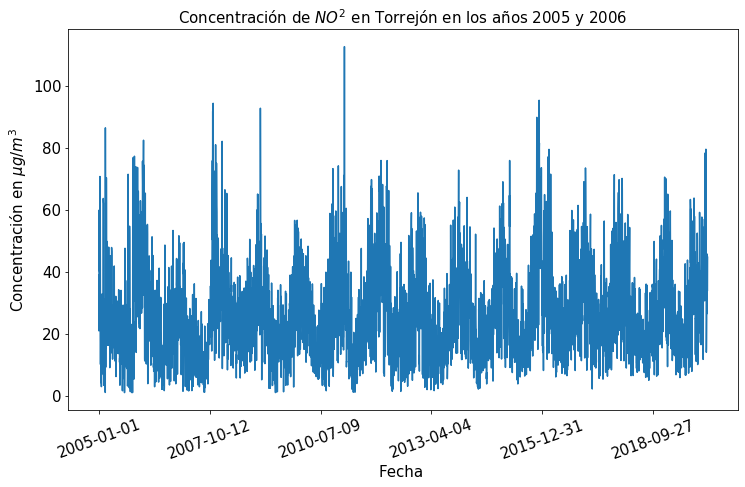

In [196]:
## Vamos a hacer un plot simple para visualizar la información
# Hay que tener cuidado con las fechas en los ejes porque las funciones que dibujan datos, no lo entiende bien
#plt.plot(fechas_np,datos_np)
#plt.show() # Despues de un plot, siempre debes incluir esta linea para que se muestre en la página

# Cuando ejecutes la celda, veras que el eje x se ve horrible. Debemos indicar que solo muestre un número concreto de fechas.
# Por ejemplo, 4 datos, simplemente es para visualizar aproximadaemnte el rango de fechas que tenemos.
fig, ax = plt.subplots(1,figsize=(12,7)) # Iniciamos un plot así cuando va a estar más "personalizado"
ax.plot(fechas_np,datos_np)
ax.set_title('Concentración de $NO^{2}$ en Torrejón en los años 2005 y 2006',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Concentración en $ \mu g / m^{3} $',fontsize=15)
ax.set_xlabel('Fecha ',fontsize=15)
ax.xaxis.set_major_locator(tck.AutoLocator())
ax.tick_params(axis='x', labelrotation = 20) # Rota los grados que quieras los "ticks" del eje x
plt.show()

# Alternativamente, puedeso optar por simplemente dibujar el vector o vectores de los datos sin información de la fecha
#plt.plot(datos_np)
#plt.show()

# Para guardar los datos, generamos otra vez una figura diferente y usamos el método correspondiente
fig.savefig('visualizacion_NO2_Torrejon_2005_2006.png',format='png', bbox_inches = 'tight') # Si te fijas, el fig de antes no ha sido modificado

In [197]:
# Vamos a calcular promedios y desviaciones estándar
# De los dos años, como ya tenemos los datos para los 2 años, es sencillo hacerlo así
media_2years = np.mean(datos_np)
desviacion_2years = np.std(datos_np)
print("Media de 2 años de datos :",media_2years)
print("Desviación estándar de 2 años de datos :",desviacion_2years)
print("----")
# Ahora, de los veranos. Esto es un poco más feo porque hay que definir el rango de posiciones (o índices del vector)
# que corresponden a tales fechas. Lo hacemos con las siguientes líneas de código.
fechas_dates = pd.to_datetime(fechas_np) # Hay que compartir las fechas a un tipo llamado datetime para operar con ellas
#fechas_veranos = np.where( (  np.datetime64('2005-06-21') < fechas_dates < np.datetime64('2005-09-21')) &
#                           (  np.datetime64('2006-06-21') < fechas_dates < np.datetime64('2006-09-21')) )[0] # Esta función identifica los índices donde se verifica la condición lógica. Los índices están almacenados en la componente 0, por eso tomamos [0]

fechas_veranos = np.where( (( np.datetime64('2005-06-21') < fechas_dates ) &
                           ( fechas_dates < np.datetime64('2005-09-21') )) |
                           (( np.datetime64('2006-06-21') < fechas_dates ) &
                           ( fechas_dates < np.datetime64('2006-09-21') )) )[0] # Esta función identifica los índices donde se verifica la condición lógica. Los índices están almacenados en la componente 0, por eso tomamos [0]


media_2years = np.mean(datos_np[fechas_veranos])
desviacion_2years = np.std(datos_np[fechas_veranos])
print("Media durante los veranos de 2 años de datos :",media_2years)
print("Desviación estándar durante los veranos de 2 años de datos :",desviacion_2years)
print("----")

# Hagamos igual en invierno
fechas_inviernos = np.where( (( np.datetime64('2005-01-01') < fechas_dates ) &
                           ( fechas_dates < np.datetime64('2005-03-21') )) |
                           (( np.datetime64('2006-01-01') < fechas_dates ) &
                           ( fechas_dates < np.datetime64('2006-03-21') )) )[0] # Esta función identifica los índices donde se verifica la condición lógica. Los índices están almacenados en la componente 0, por eso tomamos [0]

media_2years = np.mean(datos_np[fechas_inviernos])
desviacion_2years = np.std(datos_np[fechas_inviernos])
print("Media durante los inviernos de 2 años de datos :",media_2years)
print("Desviación estándar durante los inviernos de 2 años de datos :",desviacion_2years)
print("----")

# Tiene sentido este resultado mirando la gráfica?

Media de 2 años de datos : 26.58749885163848
Desviación estándar de 2 años de datos : 15.17192448222025
----
Media durante los veranos de 2 años de datos : 17.677450981152568
Desviación estándar durante los veranos de 2 años de datos : 10.174820595881648
----
Media durante los inviernos de 2 años de datos : 35.26145753401188
Desviación estándar durante los inviernos de 2 años de datos : 21.022154297627605
----


### Obtención de periodos de la señal

Las matemáticas involucradas en este cálculo matemático son complejas pero intuitivamente es fácil de entender. Podemos imaginar cualquier señal en el tiempo como una suma de señales más simples con periodicidades exactas (de igual forma que la música es la suma de notas con frecuencias muy precisas). Entonces, este algoritmo (Transformada rápida de fourier) hace los cálculos necesarios para extraer las frecuencias de nuestra señal. Hay un "espectro" de frecuencias de todos los valores, pero algunas frecuencias características, destacan sobre el resto. Por ejemplo, en las señales de contaminación, por ejemplo del O3, es obvio que se repite, aproximadamente, cada año. Entonces esperamos un "pico" en la frecuencia anual. Por otro lado, si la polución depende mucho del tráfico, es de esperar que haya otro pico en la frecuencia semanal. Los picos determinan procesos repetitivos subyacentes, que si podemos identificar su naturaleza, explican mucho de los datos que estamos analizando.


Para visualizar bien estos picos, se han representado los datos de una forma peculiar. El **eje x es el logaritmo en base diez de la frecuencia en unidades de 1/años**

C:\Users\jgomezg\AppData\Local\Temp\ipykernel_85232\3623240626.py:13: RuntimeWarning: divide by zero encountered in log10
  return s_datosf_sq[0:len(freq)//2], np.log10(freq[0:len(freq)//2])


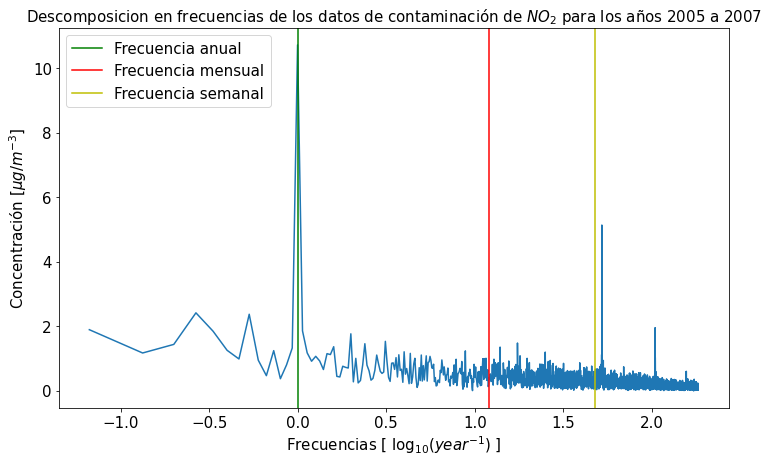

In [198]:
inv_dt = 1./365. # En caso de que la señal sea observada diariamente, expresamos esta cantidad así. En caso horario, sería ((1./24.)/365.)
componentesFrecuencias, frecuencias = frecuenciasInternas(datos_np,inv_dt)
fig, ax = plt.subplots(1,figsize=(12,7))
plt.plot(frecuencias,componentesFrecuencias)
# Dejo indicada algunas frecuencias o periodos que probablemente coincidan con los picos
fq_anual = np.log10(1) # Frecuencia anual
fq_mensual = np.log10(12.) # Frecuencia mensual
fq_semanal = np.log10(4.*12.) # Frecuencia semanal
ax.axvline(x = fq_anual, color = 'g', label = 'Frecuencia anual')
ax.axvline(x = fq_mensual, color = 'r', label = 'Frecuencia mensual')
ax.axvline(x = fq_semanal, color = 'y', label = 'Frecuencia semanal')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylabel('Concentración [$\mu g / m^{-3}$]',fontsize=15)
ax.set_xlabel('Frecuencias [ $ \log_{10} ( year^{-1} ) $ ]',fontsize=15)
ax.set_title('Descomposicion en frecuencias de los datos de contaminación de $NO_{2}$ para los años 2005 a 2007',fontsize=15)
ax.legend(fontsize=15)
 
plt.show()

### ¿Que ocurre si en vez de usar solo dos años de datos, usamos 10 o 15 o todos?
### ¿A que frecuencia corresponde el último pico que no destaco?
### ¿Hay algun fenómeno que afecte mensualm

NameError: name 'est56NO2_df' is not defined

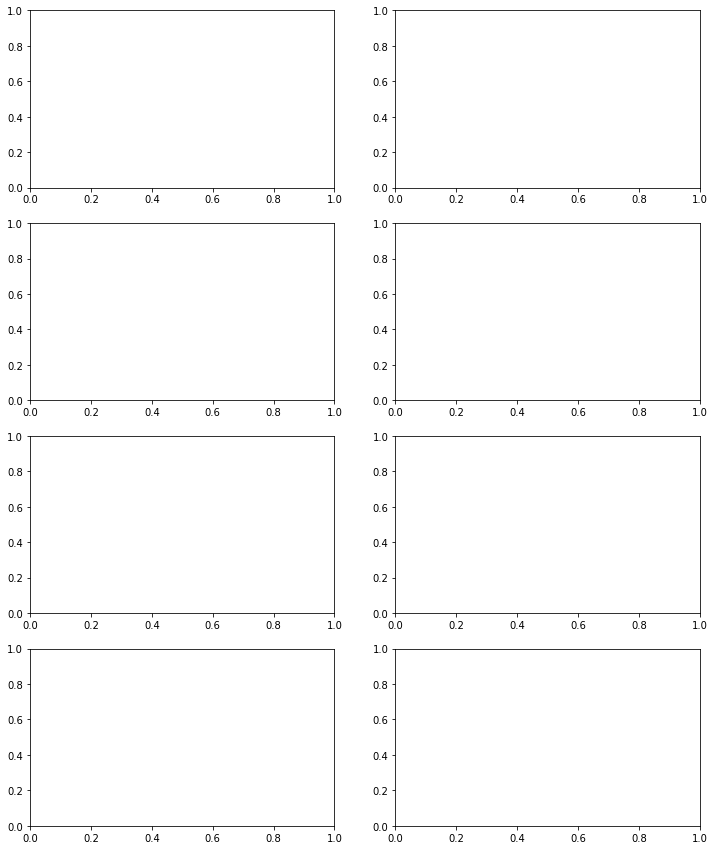

In [126]:
def frecuenciasInternas(datos,dx):
  '''
  Dada una serie de datos devuelve el espectro de frecuencias que lo compone y el dominio espectral correspondiente
  dx la unidad minima en la que el dominio esta particionado
  '''
  datosf = fft(datos)


  x = np.linspace(0.0, len(datos)*dx, len(datos))
  xf = np.linspace(0.0, (2*np.pi)/(len(datos)*dx), len(datos)//2)

  s_datosf_sq = np.real((2./len(datos))*np.sqrt(np.multiply(datosf,np.conj(datosf)))[0:len(datos)//2])

  return s_datosf_sq, xf



grid_plots_datos, [(axg1,axg5),(axg2,axg6),(axg3,axg7),(axg4,axg8)] = plt.subplots(4,2,figsize=(12,15))
est56NO2_np = est56NO2_df.to_numpy()
est24NO2_np = est24NO2_df.to_numpy()
est03NO2_np = est03NO2_df.to_numpy()
est03O3_np = est03O3_df.to_numpy()
x = np.linspace(0,10,len(est03O3_np))
print(len(est03O3_np))

axg1.plot(x,est56NO2_np)
axg1.set_title("NO2 Fernandez Ladreda")
axg1.set_ylabel("Medida / $\mu / m^{3}$")
axg2.plot(x,est24NO2_np)
axg2.set_title("NO2 Casa de Campo")
axg2.set_ylabel("Medida / $\mu / m^{3}$")
axg3.plot(x,est03NO2_np)
axg3.set_title("NO2 Plaza del Carmen")
axg3.set_ylabel("Medida / $\mu / m^{3}$")
axg4.plot(x,est03O3_np)
axg4.set_title("O3 Plaza del Carmen")
axg4.set_xlabel("Tiempo / años")
axg4.set_ylabel("Medida / $\mu / m^{3}$")

# Frecuencias
frecuencias56, xf56 = frecuenciasInternas(est56NO2_np[:,0],1.)
frecuencias24, xf24 = frecuenciasInternas(est24NO2_np[:,0],1.)
frecuencias03NO2, xf03NO2= frecuenciasInternas(est03NO2_np[:,0],1.)
frecuencias03O3, xf03O3 = frecuenciasInternas(est03O3_np[:,0],1.)

#periodos56 = np.arange(len(frecuencias56))*((2*np.pi)/(len(est56NO2_np)*(1./365)))
periodos56 = np.linspace(0,365./2.,len(frecuencias56))

periodos24 = np.linspace(0,365./2.,len(frecuencias56))

periodos03NO2 = np.linspace(0,365./2.,len(frecuencias56))

periodos03O3 = np.linspace(0,365./2.,len(frecuencias56))

axg5.plot(np.log10(periodos56),frecuencias56)
axg5.set_title("NO2 Fernandez Ladreda")
axg5.set_ylabel("Medida / $\mu g/ m^{3}$")
axg6.plot(np.log10(periodos24),frecuencias24)
axg6.set_title("NO2 Plaza del Carmen")
axg6.set_ylabel("Medida / $\mu g/ m^{3}$")
axg7.plot(np.log10(periodos03NO2),frecuencias03NO2)
axg7.set_title("NO2 Casa de campo")
axg7.set_ylabel("Medida / $\mu g/ m^{3}$")
axg8.plot(np.log10(periodos03O3),frecuencias03O3)
axg8.set_title("O3 Casa de Campo")
axg8.set_xlabel("frecuencia / log10 (años⁻¹) ")
axg8.set_ylabel("Medida / $\mu g/ m^{3}$")

grid_plots_datos.show()

#print( "Frecuencia promedio de la señal :",   np.sum(   np.multiply(   periodos , frecuencias/np.sum(frecuencias)    )    )    )
#frecuenciaMaxima = np.where(frecuencias == np.amax(frecuencias)) # Operador & para evaular elemento a elemento entre arrays
#print("frecuencia maxima :",frecuencias[frecuenciaMaxima])
#print( "Frecuencia máxima de la señal :", periodos[frecuenciaMaxima])
#for i in range(1917):
#  print(frecuencias56[i],frecuencias24[i],frecuencias03O3[i],frecuencias03NO2[i],np.log10(periodos03O3)[i])